<a href="https://colab.research.google.com/github/jdchen5/machinelearninglabs/blob/main/W22/IMP-PCMLAI-M22-2-cifar10-JC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10


Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
# Use FashionMNIST

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])  # Adjusted for a single channel


trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')


100%|██████████| 26421880/26421880 [00:02<00:00, 11770849.76it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 198364.76it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3748792.12it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5945010.19it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Let us show some of the training images, for fun.



Shape of tensor: torch.Size([4, 1, 28, 28])
Data type of tensor: torch.float32
Max value in the tensor: tensor(1.)
Min value in the tensor: tensor(-1.)


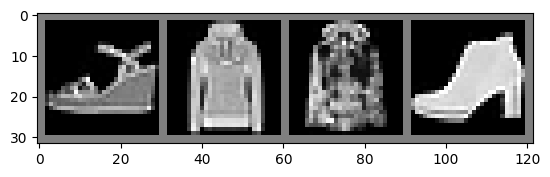

Sandal Pullover  Coat Ankle boot


In [5]:
import torchvision
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

def imshow(img):

    # Rescale the images from [-1, 1] to [0, 1]
    img = (img + 1) / 2
    # Ensure the rescaling does not push the data beyond [0, 1]
    img = img.clamp(0, 1)

    # Convert tensor to PIL Image and display
    img = to_pil_image(img)
    plt.imshow(img)
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Print the shape of the tensor
print("Shape of tensor:", images.shape)

# Print the data type of the tensor
print("Data type of tensor:", images.dtype)

# Print the maximum and minimum values (helpful to understand the normalization)
print("Max value in the tensor:", images.max())
print("Min value in the tensor:", images.min())

# Show images
imshow(make_grid(images, nrow=4))  # Adjust 'nrow' if you changed the batch size; this line will kill the kernel

# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))


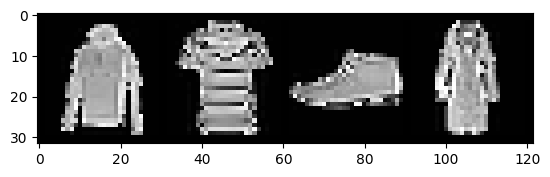

Pullover T-shirt/top Ankle boot  Coat


In [6]:
import torchvision
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

def imshow(img):
    # Convert tensor to PIL Image and display
    img = to_pil_image(img)
    plt.imshow(img)
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(make_grid(images, nrow=4))  # Adjust 'nrow' if you changed the batch size

# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))


2. Define a Convolutional Neural Network


Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [7]:
# Convolutional Neural Network Adjustment
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, name=None):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)  # Adjusted for 1 input channel, 10 output channels, and 5x5 kernel
        self.pool = nn.MaxPool2d((3, 2), (2, 2))  # Adjusted kernel size and stride
        # Assuming the same second convolution layer
        self.conv2 = nn.Conv2d(10, 16, 5)
        # Adjusted fully connected layer sizes based on the new output size from the convolutions and pooling
        self.fc1 = nn.Linear(16 * 3 * 4, 120)  # This size might need adjustment based on actual output size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print("Shape after conv1 and pool:", x.shape)

        x = self.pool(F.relu(self.conv2(x)))
        #print("Shape after conv2 and pool:", x.shape)

        # Adjust the view to match the new dimensions from the pooling layers
        x = x.view(-1, 16 * 3 * 4)  # This needs to match the actual size
        #print("Shape before fc1:", x.shape)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net(name='ModifiedNet')

# The rest of the training and evaluation code remains largely the same.


3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [8]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (Stochastic Gradient Descent with momentum)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network


This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize. We will also use the `time` package to get the training time of the network.



In [9]:
import time

start = time.time()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 2000}')
            running_loss = 0.0

print('Finished Training')

end = time.time()
print('training time ', end-start)

Epoch 1, Batch 2000, Loss: 1.3393914999980479
Epoch 1, Batch 4000, Loss: 0.6847930825250224
Epoch 1, Batch 6000, Loss: 0.5868463221101556
Epoch 1, Batch 8000, Loss: 0.5288624206119567
Epoch 1, Batch 10000, Loss: 0.4957775112332893
Epoch 1, Batch 12000, Loss: 0.46959387648673145
Epoch 1, Batch 14000, Loss: 0.42740812092024133
Epoch 2, Batch 2000, Loss: 0.40209249659796475
Epoch 2, Batch 4000, Loss: 0.4072118996489444
Epoch 2, Batch 6000, Loss: 0.38743520578704194
Epoch 2, Batch 8000, Loss: 0.3950617656071554
Epoch 2, Batch 10000, Loss: 0.3776208692994551
Epoch 2, Batch 12000, Loss: 0.35383345308879505
Epoch 2, Batch 14000, Loss: 0.3444054129990545
Finished Training
training time  158.16546368598938


5. Test the network on the test data


We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



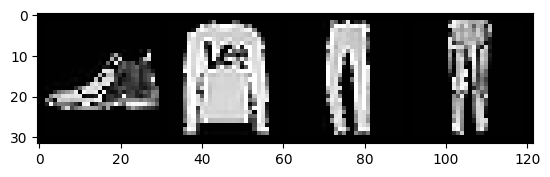

GroundTruth:  Ankle boot Pullover Trouser Trouser


In [10]:
# will kill the kernel
dataiter = iter(testloader)
#images, labels = dataiter.next()
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))  # will kill the kernel
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [11]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  Ankle boot Pullover Trouser Trouser


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 86 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of T-shirt/top : 88 %
Accuracy of Trouser : 96 %
Accuracy of Pullover : 75 %
Accuracy of Dress : 87 %
Accuracy of  Coat : 90 %
Accuracy of Sandal : 95 %
Accuracy of Shirt : 43 %
Accuracy of Sneaker : 94 %
Accuracy of   Bag : 96 %
Accuracy of Ankle boot : 96 %


Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

Training on multiple GPUs
-------------------------
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.



